In [1]:
%matplotlib widget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sysidentpy.metrics import root_relative_squared_error
import scipy.stats as stats

SRCdata = "pump_station_data"

df = pd.read_pickle(f"data/{SRCdata}_filtered.pkl")    


# Plotting

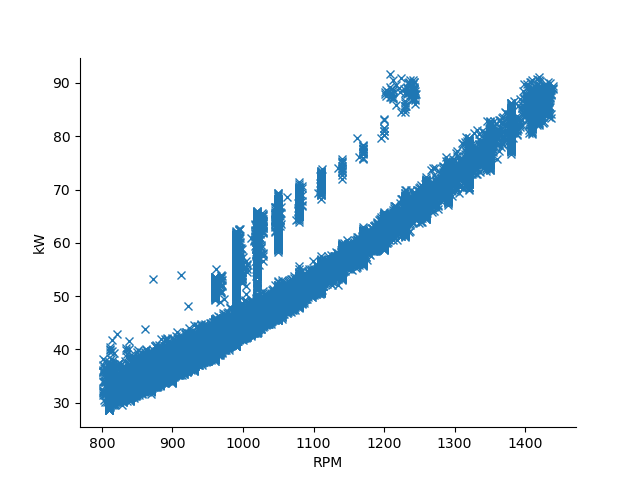

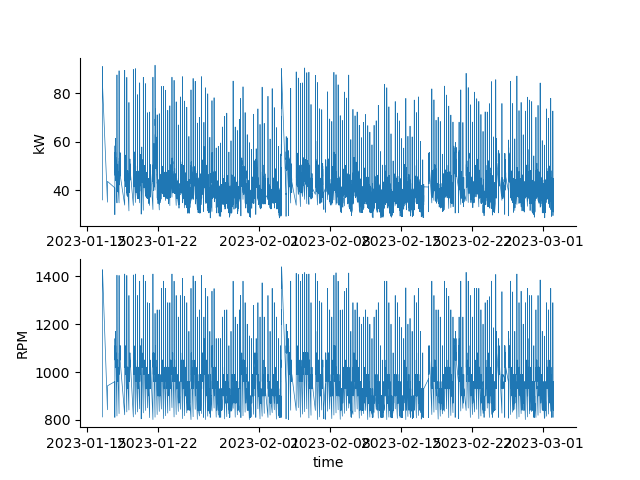

In [2]:


plt.figure()
plt.plot(df["pump4_rpm"],df["pump4_power"],marker="x",linewidth=0)
plt.xlabel("RPM")
plt.ylabel("kW")
plt.show()

plt.figure()
plt.subplot(2,1,1)
plt.plot(df["pump4_power"].index,df["pump4_power"].values,linewidth=0.5)
plt.ylabel("kW")
plt.subplot(2,1,2)
plt.plot(df["pump4_rpm"].index,df["pump4_rpm"].values,linewidth=0.5)
plt.xlabel("time")
plt.ylabel("RPM")
plt.show()

# Building the Model

c:\Users\manis\anaconda3\Lib\site-packages\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


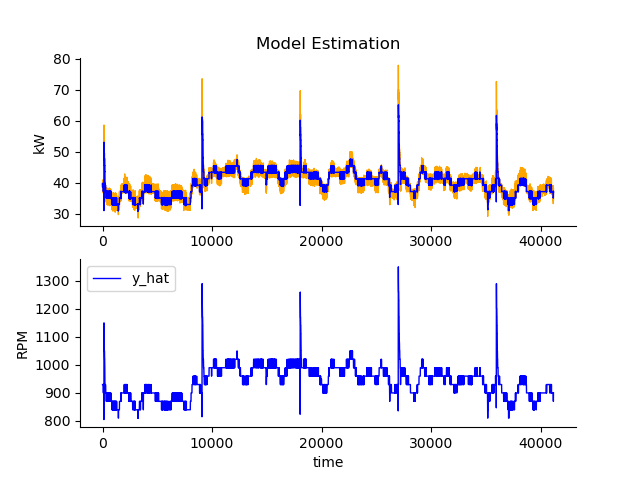

In [3]:
# n_terms set to 4 and no order selection.
basis_function = Polynomial(degree=1) 
model = FROLS( 
    order_selection=True, 
    n_info_values=10, 
    extended_least_squares=False,
    ylag=5, 
    xlag=5,
    info_criteria="aic", 
    estimator="least_squares", 
    basis_function=basis_function, )


# Select One Day of data to build the model

test_data  = df[["pump4_rpm","pump4_power"]].loc['2023-03-01':'2023-03-02']
train_data  = df[["pump4_rpm","pump4_power"]].loc['2023-02-27':'2023-03-01']


ytest = test_data["pump4_power"].values.reshape(-1,1)
ytrain = train_data["pump4_power"].values.reshape(-1,1)

xtest = test_data["pump4_rpm"].values.reshape(-1,1)
xtrain = train_data["pump4_rpm"].values.reshape(-1,1)

# Training the ARX model
model.fit(X=xtrain, y=ytrain)

# Prediciting on input sequence xtest
yhat = model.predict(X=xtest, y=ytest)

plt.figure()

ax1 = plt.subplot(2,1,1)
plt.plot(ytest,color='orange',linewidth=1,label='y')
plt.plot(yhat,color='blue',linewidth=1,label='y_hat')
plt.ylabel('kW')
plt.title('Model Estimation')
# Shared x-axis
ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(xtest,color='blue',linewidth=1,label='y_hat')
plt.xlabel('time')
plt.ylabel('RPM')
plt.legend()
plt.show()  


# Observations
The power measurement is subject to noise as can be seen at a steady state condition where power draw should somewhat be constant. However it could also be unmodelled system dynamics.

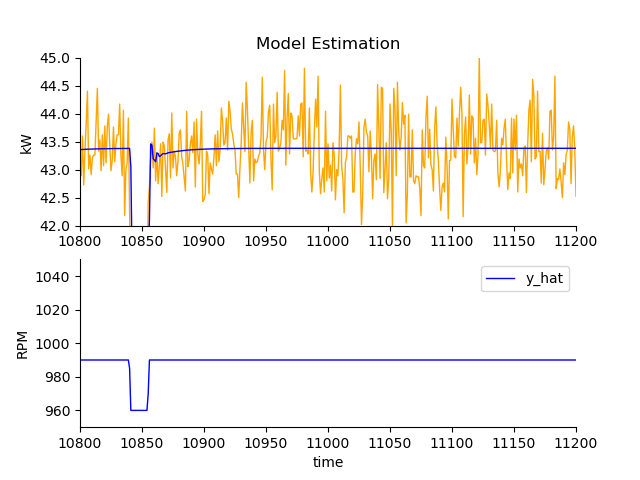

In [4]:
plt.figure()

ax1 = plt.subplot(2,1,1)
plt.plot(ytest,color='orange',linewidth=1,label='y')
plt.plot(yhat,color='blue',linewidth=1,label='y_hat')
plt.ylabel('kW')
plt.title('Model Estimation')
plt.ylim((42,45))
# Shared x-axis
ax2 = plt.subplot(2,1,2, sharex=ax1)
plt.plot(xtest,color='blue',linewidth=1,label='y_hat')
plt.xlabel('time')
plt.ylabel('RPM')
plt.legend()
plt.xlim((10800,11200))
plt.ylim((950,1050))
plt.show()  

# Evaluate

In [5]:
mae  = sklearn.metrics.mean_absolute_error(ytest, yhat)
mse  = sklearn.metrics.mean_squared_error(ytest, yhat)
rmse = np.sqrt(mse)
rrse = root_relative_squared_error(ytest, yhat)
print("MAE = " + str(mae))
print("MSE = " + str(mse))
print("RMSE = " + str(rmse))
print("RRSE = " + str(rrse))


r = pd.DataFrame(
    results(
        model.final_model,
        model.theta,
        model.err,
        model.n_terms,
        err_precision=8,
        dtype="sci",
    ),
    columns=["Regressors", "Parameters", "ERR"],
)
print(r)



MAE = 0.851624210497269
MSE = 1.2980937031601372
RMSE = 1.1393391519473635
RRSE = 0.28494237115468646
  Regressors   Parameters             ERR
0     y(k-1)   2.6441E-01  9.99383715E-01
1     y(k-3)   2.2850E-01  9.97169307E-05
2    x1(k-1)   6.5653E-02  1.25128727E-05
3    x1(k-3)  -1.4076E-02  4.04290784E-05
4     y(k-4)   1.7736E-01  2.19151670E-05
5          1  -4.1617E+00  1.24205768E-05
6    x1(k-5)  -1.8265E-02  4.79524358E-06
7     y(k-5)   1.6462E-01  9.56912838E-06
8    x1(k-2)  -1.1826E-02  6.39992683E-07
9    x1(k-4)  -1.0046E-02  5.21333686E-07


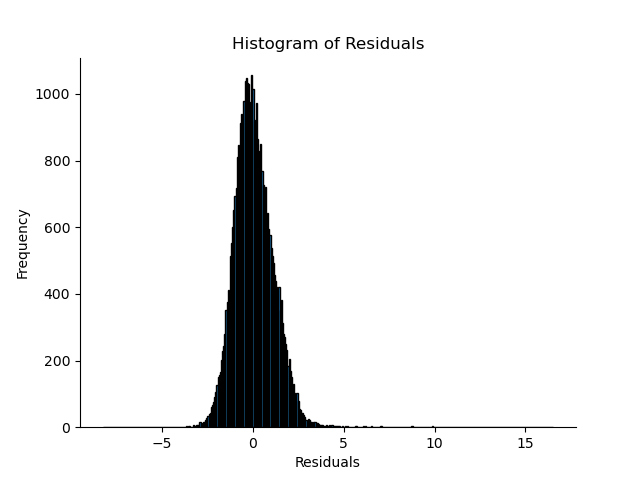

Shapiro-Wilk Test Statistic: 0.9366474151611328, P-value: 0.0
The residuals do not follow a normal distribution (reject H0)


c:\Users\manis\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


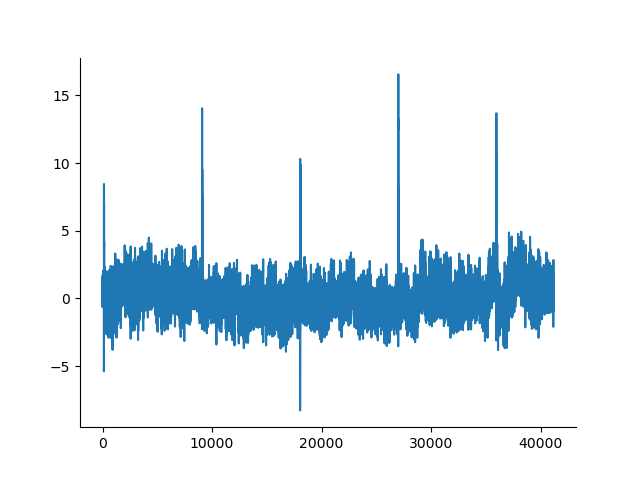

In [6]:
residuals = ytest - yhat

plt.figure()
plt.plot(residuals)
# Plotting the histogram of residuals
plt.figure()
plt.hist(residuals, bins=400, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

shapiro_test = stats.shapiro(residuals)

print(f"Shapiro-Wilk Test Statistic: {shapiro_test[0]}, P-value: {shapiro_test[1]}")

# Interpretation
alpha = 0.05
if shapiro_test[1] < alpha:
    print("The residuals do not follow a normal distribution (reject H0)")
else:
    print("The residuals follow a normal distribution (fail to reject H0)")

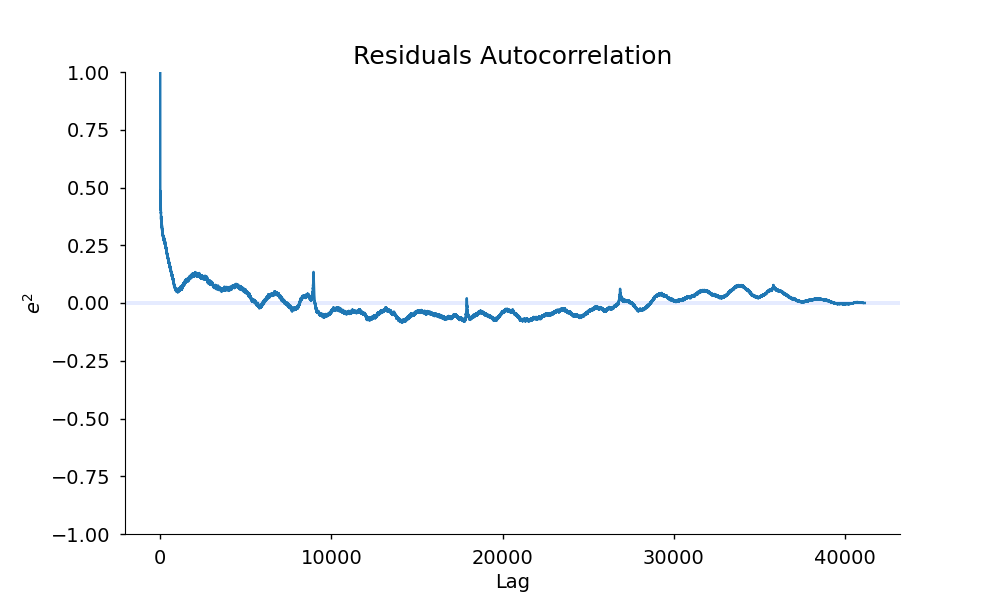

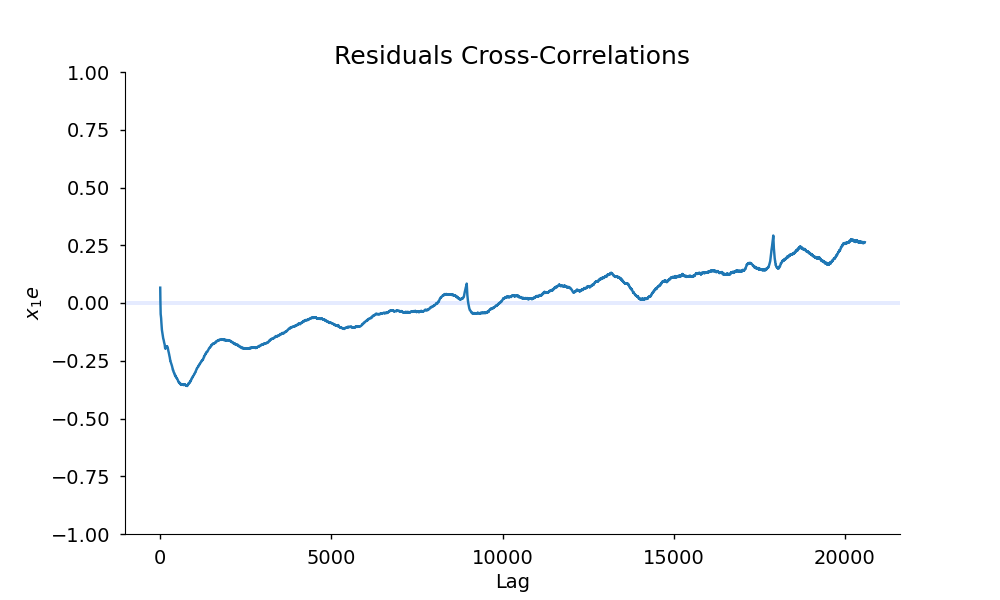

In [7]:
#print(plt.style.available)
# If seaborn-v0_8-notebook style is not available, 
# pick a random style from the ones available in yout matplotlib

ee = compute_residues_autocorrelation(ytest, yhat) #Correlation of the residual with itself
#========================
#Plot the residuals correlation or autocorrelation.
plot_residues_correlation(data=ee, title="Residuals Autocorrelation",
                          ylabel="$e^2$", 
                          style='seaborn-v0_8-notebook')
#========================
#Plot the cross-correlation of the residuals. 
x1e = compute_cross_correlation(ytest, yhat, xtest)
plot_residues_correlation(data=x1e, title="Residuals Cross-Correlations", 
                          ylabel="$x_1e$", 
                          style='seaborn-v0_8-notebook')